In [1]:
import pandas as pd
import numpy as np
import re
import string

In [2]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, SpatialDropout1D, Conv1D,MaxPool1D,BatchNormalization, GRU, SimpleRNN, Dropout,Flatten, concatenate,Bidirectional, GlobalMaxPool1D
from tensorflow.keras import utils 
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
import matplotlib.pyplot as plt 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import random
import time
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import brown
from textblob import TextBlob
from tensorflow.keras import regularizers
from keras.initializers import Constant


In [3]:


import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)



In [4]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 

In [5]:
tweets_train.text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
tweets_train['cleaned_text'] = tweets_train['text'].apply(lambda x: clean_text(x))

In [8]:
tweets_test['cleaned_text'] = tweets_test['text'].apply(lambda x: clean_text(x))

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
tweets_train['cleaned_text']=tweets_train['cleaned_text'].apply(lambda x: remove_emoji(x))

In [10]:
train_text_emb = tweets_train.cleaned_text
test_emb = tweets_test.cleaned_text
train_target_emb = tweets_train.target

In [11]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text_emb)
vocab_length = len(word_tokenizer.word_index) + 1

In [12]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [13]:
longest_train = max(train_text_emb, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_text_emb), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_emb), length_long_sentence, padding='post')

In [14]:
padded_sentences

array([[ 107, 4290,   20, ...,    0,    0,    0],
       [ 174,   42,  208, ...,    0,    0,    0],
       [  39, 1630, 1506, ...,    0,    0,    0],
       ...,
       [ 210,    5,  558, ...,    0,    0,    0],
       [  75, 1064,   37, ...,    0,    0,    0],
       [   1,  193,   51, ...,    0,    0,    0]], dtype=int32)

In [19]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('Dataset/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [22]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [24]:
length_long_sentence

31

In [25]:
model=Sequential()

embedding=Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],embeddings_initializer=Constant(embedding_matrix),
                   input_length=length_long_sentence,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [26]:
y = np.asarray(train_target_emb)

In [27]:
xTrain, xVal, yTrain, yVal = train_test_split(padded_sentences, y, test_size=0.25)

In [28]:
xVal.shape

(1904, 31)

In [31]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(xTrain,yTrain,epochs=10,batch_size=1, validation_data=(xVal, yVal), verbose = 1, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
5709/5709 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.7660
Epoch 00001: val_loss improved from inf to 0.46018, saving model to model.h5
5709/5709 [==============================] - 240s 42ms/step - loss: 0.5123 - accuracy: 0.7660 - val_loss: 0.4602 - val_accuracy: 0.7883
Epoch 2/10
5709/5709 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.7858
Epoch 00002: val_loss improved from 0.46018 to 0.45619, saving model to model.h5
5709/5709 [==============================] - 250s 44ms/step - loss: 0.4784 - accuracy: 0.7858 - val_loss: 0.4562 - val_accuracy: 0.8057
Epoch 3/10
5708/5709 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.7992
Epoch 00003: val_loss improved from 0.45619 to 0.42907, saving model to model.h5
5709/5709 [==============================] - 153s 27ms/step - loss: 0.4584 - accuracy: 0.7991 - val_loss: 0.4291 - val_accuracy: 0.8051
Epoch 4/10
5707/5709 [============================>.] - ETA

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 50)            841700    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 31, 62)            20336     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 62)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62)                248       
_________________________________________________________________
dropout_3 (Dropout)          (None, 62)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 31)                1953      
_________________________________________________________________
dropout_4 (Dropout)          (None, 31)               

In [33]:
import matplotlib.pyplot as plt
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)


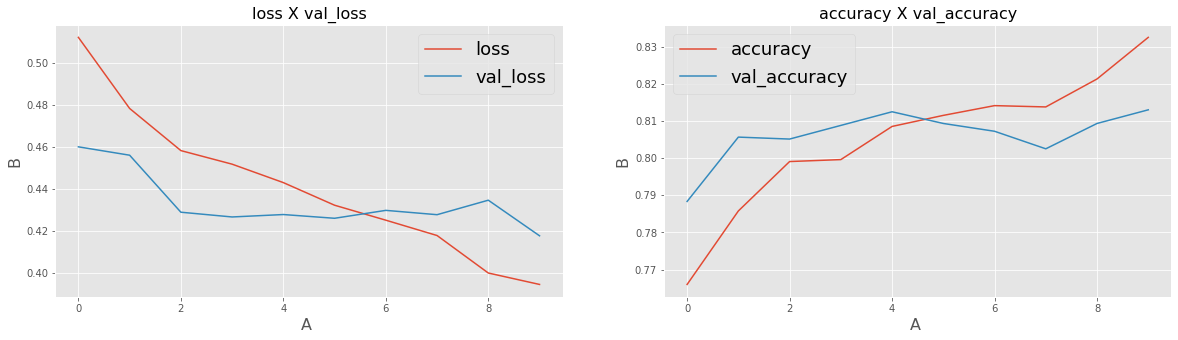

In [34]:


plot(history, [['loss', 'val_loss'],['a
Epoch 00010: val_loss improved from 0.42618 to 0.41784, saving model to model.h5
5709/5709 [==============================] - 164s 29ms/step - loss: 0.3947 -ccuracy', 'val_accuracy']])



In [31]:
loss, accuracy = model.evaluate(xVal, yVal)
print('Loss:', loss)
print('Accuracy:', accuracy)

48/48 [==============================] - 0s 7ms/step - loss: 1.2682 - accuracy: 0.7833
Loss: 1.2681571245193481
Accuracy: 0.7833223938941956


In [33]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))


In [34]:
preds = model.predict_classes(xVal)
metrics(preds, yVal)

F1-score:  0.7268211920529801
Precision:  0.6753846153846154
Recall:  0.7867383512544803
Acuracy:  0.783322390019698
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       965
           1       0.68      0.79      0.73       558

    accuracy                           0.78      1523
   macro avg       0.77      0.78      0.77      1523
weighted avg       0.79      0.78      0.79      1523



In [35]:
model.load_weights('model.h5')
preds = model.predict_classes(xVal)
metrics(preds, yVal)

F1-score:  0.7337488869100623
Precision:  0.6338461538461538
Recall:  0.8710359408033826
Acuracy:  0.8036769533814839
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1050
           1       0.63      0.87      0.73       473

    accuracy                           0.80      1523
   macro avg       0.78      0.82      0.79      1523
weighted avg       0.84      0.80      0.81      1523



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


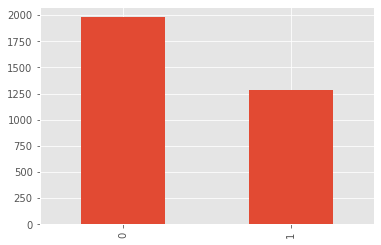

In [35]:
tweets_submission.target = model.predict_classes(test_sentences)
tweets_submission.to_csv("submission.csv", index=False)
tweets_submission.target.value_counts().plot.bar();